C:\Users\jgilg\AppData\Local\Temp\ipykernel_52968\3960441101.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


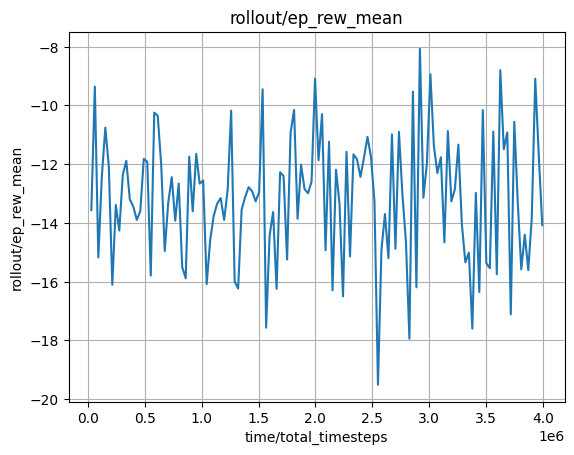

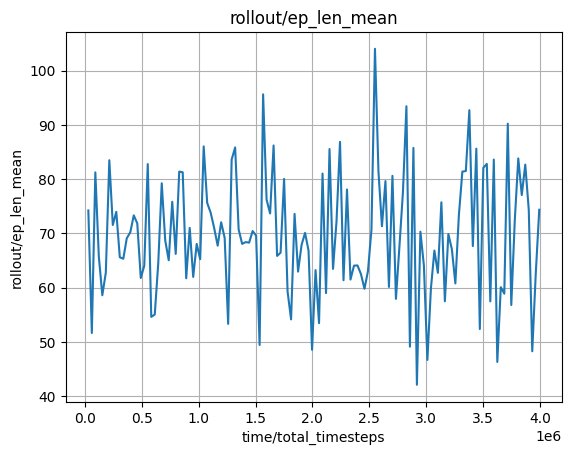

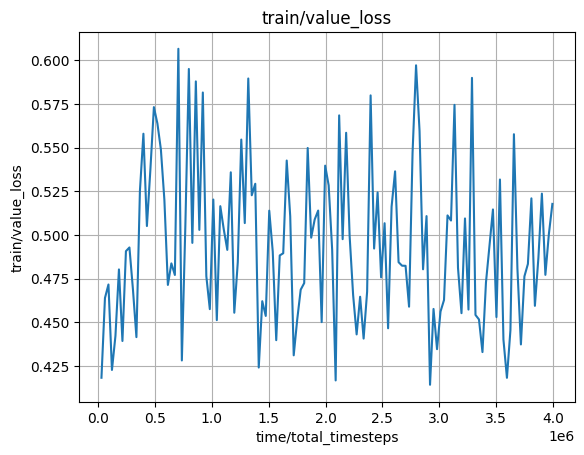

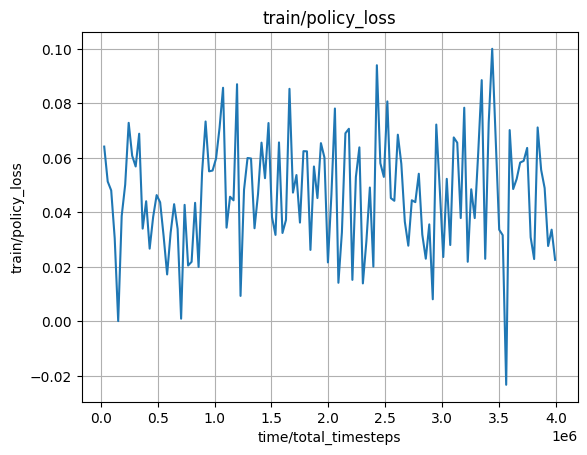

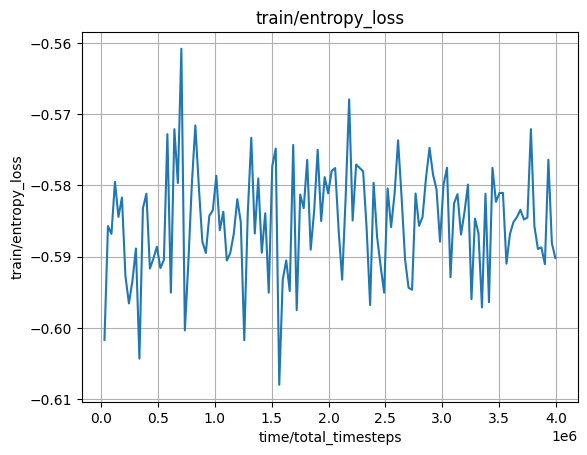

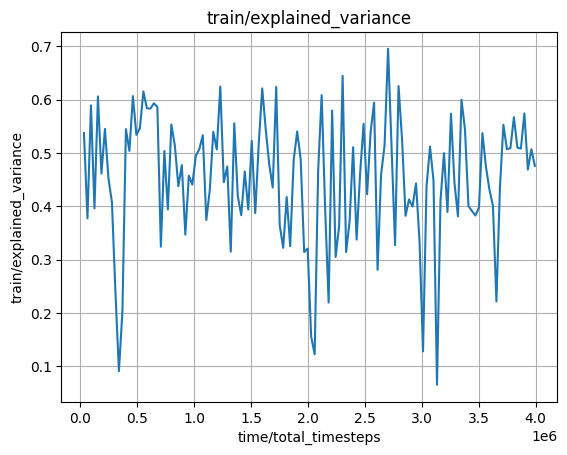

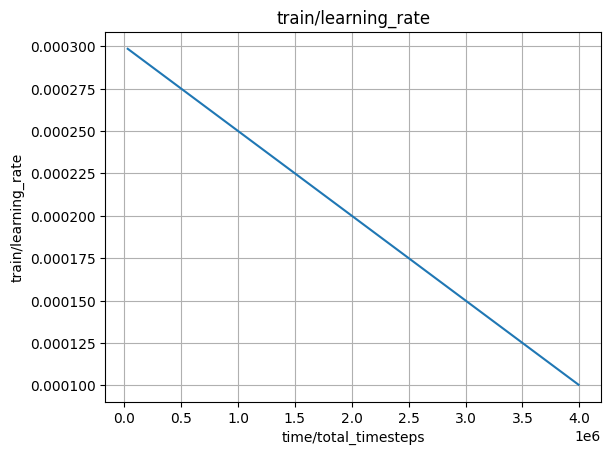


Correlación con rollout/ep_rew_mean:
rollout/ep_rew_mean     1.000000
train/entropy_loss      0.050167
train/learning_rate     0.009354
train/ent_coef          0.009354
time/fps               -0.005567
time/time_elapsed      -0.006648
time/iterations        -0.009354
train/n_updates        -0.009354
time/total_timesteps   -0.009354
train/value_loss       -0.062318
Name: rollout/ep_rew_mean, dtype: float64


In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt

ronda = "18"
csv_path = f"./logs/tb-a2c/ronda_{ronda}/csv/progress.csv"  # ← cámbialo

# Lee el CSV y fuerza numérico donde pueda (valores raros serán NaN)
df = pd.read_csv(csv_path)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="ignore")

# Eje X: total_timesteps si existe; si no, iterations; si no, índice
x = (df["time/total_timesteps"])
x_label = "time/total_timesteps" if "time/total_timesteps" in df else ("time/iterations" if "time/iterations" in df else "index")

# Métricas a graficar (pon/quita a tu gusto)
metrics = [
    "rollout/ep_rew_mean",
    "rollout/ep_len_mean",
    "train/value_loss",
    "train/policy_loss",
    "train/entropy_loss",
    "train/explained_variance",
    "train/learning_rate"

]

for m in metrics:
    if m in df.columns:
        plt.figure()
        plt.plot(x, pd.to_numeric(df[m], errors="coerce"))
        plt.title(m)
        plt.xlabel(x_label)
        plt.ylabel(m)
        plt.grid(True)
        plt.show()

# (Opcional) correlación express con la recompensa media
if "rollout/ep_rew_mean" in df.columns:
    num = df.select_dtypes("number")
    corr = num.corr(numeric_only=True)["rollout/ep_rew_mean"].sort_values(ascending=False)
    print("\nCorrelación con rollout/ep_rew_mean:")
    print(corr.dropna().head(10))

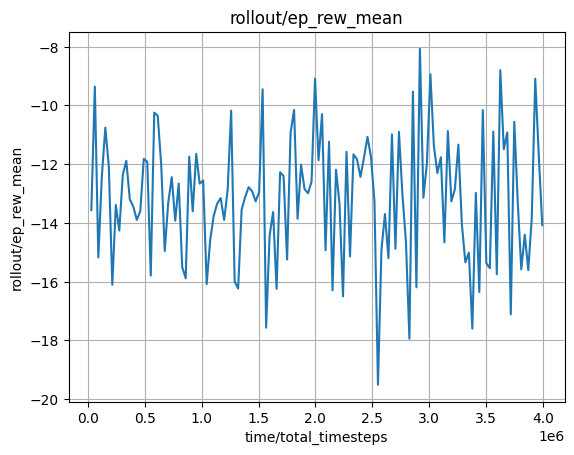

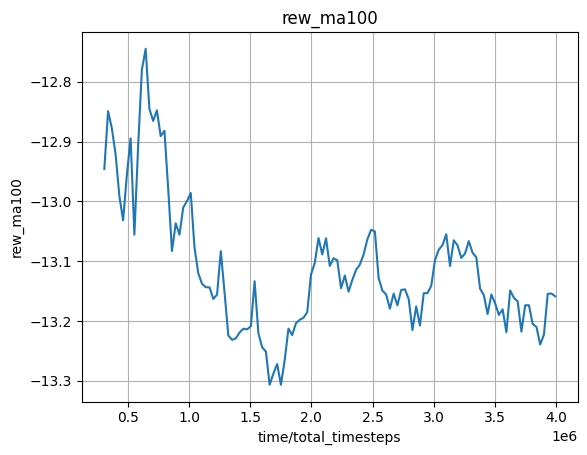


== Lag correlations (y=ep_rew_mean vs x lagged by k) ==

train/value_loss (lag k means x at t-k):
0    -0.062
1    -0.071
2    -0.123
3     0.085
4     0.023
5     0.025
6     0.014
7     0.050
8    -0.107
9     0.039
10   -0.154

train/entropy_loss (lag k means x at t-k):
0     0.050
1     0.065
2    -0.031
3     0.153
4     0.034
5     0.040
6     0.117
7    -0.060
8    -0.035
9    -0.177
10    0.038

rollout/ep_len_mean (lag k means x at t-k):
0    -0.995
1     0.113
2    -0.122
3    -0.009
4     0.111
5     0.032
6     0.004
7     0.169
8     0.011
9    -0.098
10    0.020


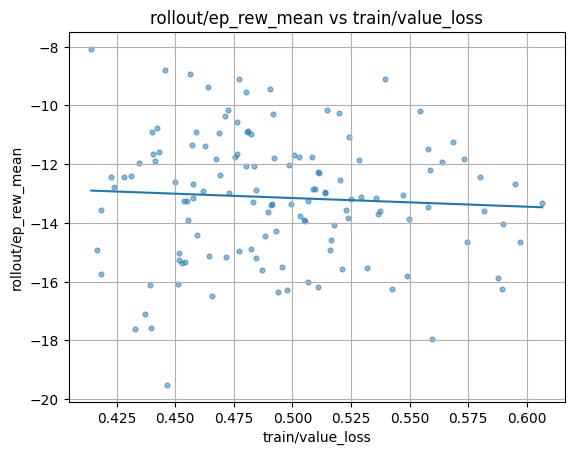

Pearson(rollout/ep_rew_mean,train/value_loss) = -0.062


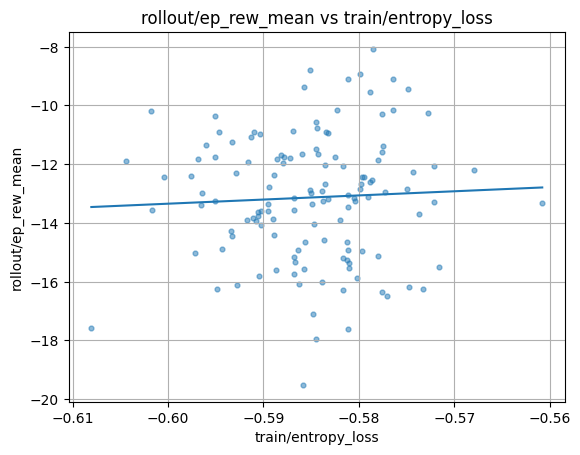

Pearson(rollout/ep_rew_mean,train/entropy_loss) = 0.050


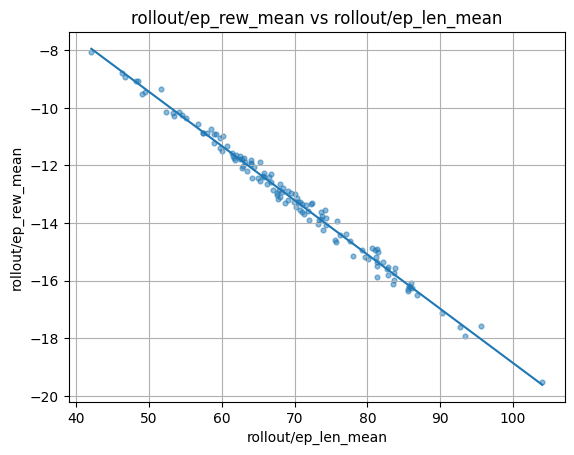

Pearson(rollout/ep_rew_mean,rollout/ep_len_mean) = -0.995

Spearman con rollout/ep_rew_mean:
rollout/ep_rew_mean     1.000000
rew_ma100               0.232929
train/entropy_loss      0.041691
time/time_elapsed       0.006634
time/total_timesteps    0.006634
time/iterations         0.006634
train/n_updates         0.006634
train/learning_rate    -0.006634
train/ent_coef         -0.006634
time/fps               -0.028779
Name: rollout/ep_rew_mean, dtype: float64


In [31]:
import numpy as np

# 1) Suavizados de recompensa
if "rollout/ep_rew_mean" in df.columns:
    df = df.copy()
    df["rew_ma100"] = pd.to_numeric(df["rollout/ep_rew_mean"], errors="coerce").rolling(100, min_periods=10).mean()
    #df["rew_ema100"] = pd.to_numeric(df["rollout/ep_rew_mean"], errors="coerce").ewm(span=100, adjust=False, min_periods=10).mean()

    x_series = df[x_label] if isinstance(x, pd.Series) else pd.Series(x)
    for col in ["rollout/ep_rew_mean", "rew_ma100"]:
        if col in df:
            plt.figure()
            plt.plot(x_series, df[col])
            plt.title(col)
            plt.xlabel(x_label)
            plt.ylabel(col)
            plt.grid(True)
            plt.show()

# 2) Correlación con desfase (lead/lag): ¿qué predice la recompensa futura?
def lag_corr(y, x, max_lag=10):
    """Corr(y_t, x_{t-lag}) para lag >=0; devuelve Serie con lags."""
    out = {}
    yv = pd.to_numeric(y, errors="coerce")
    xv = pd.to_numeric(x, errors="coerce")
    for lag in range(0, max_lag+1):
        out[lag] = yv.corr(xv.shift(lag))
    return pd.Series(out)

targets = ["train/value_loss", "train/entropy_loss", "rollout/ep_len_mean"]
if "rollout/ep_rew_mean" in df.columns:
    print("\n== Lag correlations (y=ep_rew_mean vs x lagged by k) ==")
    for t in targets:
        if t in df.columns:
            lc = lag_corr(df["rollout/ep_rew_mean"], df[t], max_lag=10)
            print(f"\n{t} (lag k means x at t-k):")
            print(lc.round(3).to_string())

# 3) Scatter con recta de tendencia
def scatter_with_trend(xvals, yvals, xname, yname):
    xnum = pd.to_numeric(xvals, errors="coerce")
    ynum = pd.to_numeric(yvals, errors="coerce")
    m = (~xnum.isna()) & (~ynum.isna())
    xnum, ynum = xnum[m], ynum[m]
    if len(xnum) < 3:
        return
    plt.figure()
    plt.scatter(xnum, ynum, s=12, alpha=0.5)
    # recta
    coef = np.polyfit(xnum, ynum, 1)
    xs = np.linspace(xnum.min(), xnum.max(), 100)
    plt.plot(xs, coef[0]*xs + coef[1])
    plt.title(f"{yname} vs {xname}")
    plt.xlabel(xname); plt.ylabel(yname); plt.grid(True)
    plt.show()
    print(f"Pearson({yname},{xname}) = {xnum.corr(ynum):.3f}")

pairs = [
    ("train/value_loss", "rollout/ep_rew_mean"),
    ("train/entropy_loss", "rollout/ep_rew_mean"),
    ("rollout/ep_len_mean", "rollout/ep_rew_mean"),
]
for xcol, ycol in pairs:
    if xcol in df.columns and ycol in df.columns:
        scatter_with_trend(df[xcol], df[ycol], xcol, ycol)

# 4) Spearman (monótona)
if "rollout/ep_rew_mean" in df.columns:
    num = df.select_dtypes("number")
    spear = num.corr(method="spearman", numeric_only=True)["rollout/ep_rew_mean"].sort_values(ascending=False)
    print("\nSpearman con rollout/ep_rew_mean:")
    print(spear.dropna().head(10))